In [59]:
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from pyspark import StorageLevel
from pyspark.sql.types import DateType

from pyspark.sql.window import Window as W
from pyspark.sql.functions import col, max as max_, min as min_
import pyspark.sql.functions as f

import pandas as pd
import numpy as np

In [2]:
rc_params = {
    #'figure.figsize' : [5, 5],
    'axes.grid' : True,
    'axes.grid.axis' : 'y',
    'axes.grid.which' : 'major',
    'axes.spines.left' : False,
    'axes.spines.bottom' : True,
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'axes.labelsize' : 20,
    'axes.titlesize' : 20,
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'xtick.top' : False,
    'xtick.bottom' : False,
    'ytick.left' : False,
    'ytick.right' : False,
    'legend.fancybox' : True,
    'legend.shadow' : False,
    'legend.frameon' : True,
    'legend.fontsize' : 12,
    'legend.title_fontsize' : 14,
    'legend.markerscale' : 2,
    'legend.framealpha' : .5,
    'errorbar.capsize' : 10,
    'pdf.fonttype' : 42,
    'ps.fonttype' : 42,
    #'font.sans-serif': ['Helvetica'], #Requires Helvetica installed
}


In [3]:
conf = SparkConf().setAll([('spark.executor.memory', '100g'), 
                           ('spark.driver.memory','100g'),
                           ('spark.ui.port','4050'),
                           ('spark.local.dir','/ada/tmp')])
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.parquet('/w/225/1/chess/tactics/parquet/glicko_user_tactics_all.parquet',header=True,inferSchema = True)

In [5]:
#Number of attempts in the dataframe
df.count()

390195808

In [4]:
#df.persist(StorageLevel.MEMORY_ONLY)
df.printSchema()

root
 |-- user_hash: string (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- user_tactics_problem_id: string (nullable = true)
 |-- varianceUser: integer (nullable = true)
 |-- varianceProblem: integer (nullable = true)
 |-- ratingProblem: integer (nullable = true)
 |-- ratingUser: integer (nullable = true)
 |-- create_date: timestamp (nullable = true)
 |-- last_game_date: timestamp (nullable = true)
 |-- is_passed: integer (nullable = true)
 |-- correct_move_count: integer (nullable = true)
 |-- tactics_problem_id: string (nullable = true)
 |-- rating_change: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- userGamesPlayed: integer (nullable = true)
 |-- max_games_played: integer (nullable = true)



In [41]:
df.select(['varianceUser','ratingUser','create_date']).show(100)

+------------+----------+-------------------+
|varianceUser|ratingUser|        create_date|
+------------+----------+-------------------+
|         350|      1720|2014-08-25 03:45:51|
|         271|      1591|2014-08-25 03:47:29|
|         218|      1454|2014-08-25 03:48:03|
|         186|      1343|2014-08-25 03:48:57|
|         169|      1392|2014-08-25 03:49:13|
|         170|      1446|2014-08-31 05:51:53|
|         153|      1370|2014-08-31 05:52:43|
|         141|      1320|2014-08-31 05:53:36|
|         134|      1298|2014-08-31 05:54:36|
|         125|      1347|2014-08-31 05:54:58|
|         132|      1309|2014-09-04 01:23:28|
|         123|      1366|2014-09-04 01:24:16|
|         116|      1323|2014-09-04 01:25:55|
|         110|      1367|2014-09-04 01:26:44|
|         138|      1400|2014-09-13 17:23:23|
|         130|      1434|2014-09-13 17:23:41|
|         122|      1474|2014-09-13 17:23:57|
|         115|      1435|2014-09-13 17:24:20|
|         109|      1463|2014-09-1

<h1>Calculate Average Performance Per User Over Time</h1>
<p>For each user calculate their average performance for each month they have played</p>

In [17]:
MONTHS = 50
GAMES = 1000
GAME_RATE = 50
MAX_SKIP = 1

<h2>Add number of games user played per attempt</h2>

In [31]:
windowSpec = W.partitionBy("user_hash").orderBy("create_date")
#Add a field with number of games played up till each attempt for each user
df = df.withColumn("userGamesPlayed",f.row_number().over(windowSpec)-1)
#Add a field with the max number of games played per user
total_games = df.groupBy('user_hash')\
.agg(max_('userGamesPlayed')).withColumnRenamed("max(userGamesPlayed)","max_games_played")
df  = df.join(total_games,"user_hash","inner")

<h2>Add a field that stores the number of months between current attempt and first attempt for each user</h2>

In [10]:
#Get the earliest date for each user that appears in the dataframe and 
#store as a new column min_date in first_dates table
first_dates = df.groupBy('user_hash') \ 
.agg(min_('create_date')) \
.withColumnRenamed("min(create_date)","min_date")
#first_dates = first_dates.withColumnRenamed("min(create_date)","min_date")
#Join min_date to each row in the original dataframe
df = df.join(first_dates, "user_hash","inner")
#Create a new column in the dataframe with the number of months since first attempt for each user
df = df.withColumn("months_played",f.months_between(f.col("create_date"),f.col("min_date")).cast('int'))
temp = df.groupBy('user_hash')\
.agg(max_('months_played')).withColumnRenamed("max(months_played)","max_months")
df  = df.join(temp,"user_hash","inner")

<h2>Add a field to control for biggest gap between months played</h2>

In [71]:
#Add a new column that contains the max number of months missed between attempts per user
dateSpec = W.partitionBy("user_hash").orderBy("create_date")
df = df.withColumn("months_skip",f.col("months_played") - f.lag("months_played").over(dateSpec))
df = df.na.fill(value=0,subset=["months_skip"])
temp = df.groupBy('user_hash').agg(max_(df.months_skip)).withColumnRenamed("max(months_skip)","max_skip")
df = df.join(temp,"user_hash","inner")

In [216]:
#Filter out attempts from users that have played less than 1000 games
#played for less than 30 months and have not skipped more than 1 month
#between attempts
exp_user = df.filter((df.max_games_played >= GAMES) & (df.max_months >= MONTHS) & (df.max_skip <= MAX_SKIP))

<h2>Filter out users based on average games per month rate</h2>

In [217]:
#Calculate games per month for each month and then average to get
#average games per month rate for each player
games_per_month = exp_user.groupBy('user_hash','months_played')\
.count()
#.count().select(['user_hash','months_played',f.col("count").alias('games_in_month')])
monthly_rate = games_per_month.groupBy('user_hash')\
.agg(f.avg(games_per_month['count'])).withColumnRenamed("avg(count)","month_rate")
exp_user = exp_user.join(monthly_rate,"user_hash","inner")

In [218]:
#Filter out users that have an average games per month rate less than 50
exp_user = exp_user.filter(exp_user.month_rate >= GAME_RATE)

<h2>For the remaining users average their rating per month</h2>

In [219]:
#Get a table of average rating per month per user
month_table = exp_user.groupby(['user_hash','months_played'])\
.agg(f.avg(exp_user.ratingUser)).persist(StorageLevel.MEMORY_ONLY)
month_table = month_table.withColumnRenamed("avg(ratingUser)","avg_rating")

In [5]:
#Read month_table
import json
month_table = spark.read.parquet('/w/225/1/chess/tactics/parquet/month_rating_table_1.parquet')

with open('/w/225/1/chess/tactics/parquet/month_rating_param_1.json') as file:
    param_dic = json.load(file)
    
MONTHS = param_dic['MONTHS']
GAMES = param_dic['GAMES']
GAME_RATE = param_dic['GAME_RATE']
MAX_SKIP = param_dic['MAX_SKIP']

In [12]:
month_table = month_table.orderBy(['user_hash','months_played']).persist(StorageLevel.MEMORY_ONLY)

In [18]:
#Get the average rating per month for all users' average monthly ratings
avg_curve = month_table.groupBy('months_played')\
.agg(f.avg(month_table.avg_rating))
avg_curve = avg_curve.orderBy('months_played',ascending=True)
avg_curve_vals = np.array(avg_curve.select('avg(avg_rating)').collect())

In [235]:
#Save table and parameters used to a parquet and JSON file respectively
import json
month_table.write.parquet('/w/225/1/chess/tactics/parquet/month_rating_table_1.parquet')
param_dic = {'MONTHS': MONTHS, 
             'GAMES': GAMES, 
             'GAME_RATE': GAME_RATE, 
             'MAX_SKIP': MAX_SKIP}
with open('/w/225/1/chess/tactics/parquet/month_rating_param_1.json','w') as outfile:
    json.dump(param_dic,outfile)

In [15]:
unique_users = month_table.select('user_hash').distinct().collect()
unique_users = [row[0] for row in unique_users]
n_users = len(unique_users)
print('There are {} unique users remaining'.format(n_users))

There are 1424 unique users remaining


In [20]:
import random
N_RAND = 200
rand_users = random.sample(unique_users,N_RAND)

In [21]:
#Filter out to get the first N games for each user in rand_users
rand_user_attempts = month_table.filter((month_table.user_hash.isin(rand_users)) & (month_table.months_played <= MONTHS))
#Order by user_hash and months_played so the ratings appear in the right
#order per user
rand_user_attempts = rand_user_attempts.orderBy(['user_hash','months_played'],ascending=True)

user_rating_vals = np.array(rand_user_attempts.select('avg_rating').collect())
user_rating_vals = user_rating_vals.reshape(N_RAND,MONTHS + 1)

In [22]:
len(user_rating_vals)

200

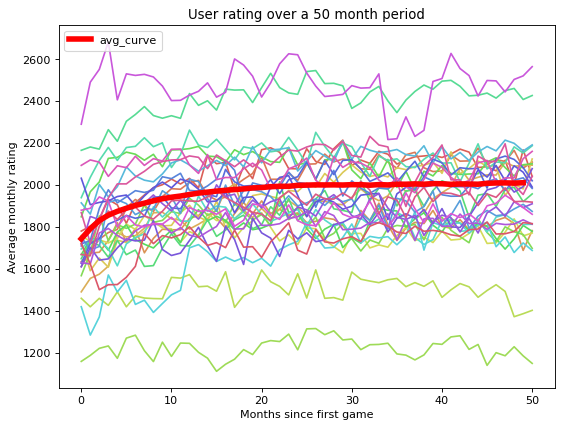

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
N_RAND = 30
colors = sns.color_palette("hls", N_RAND)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,player in enumerate(user_rating_vals[:N_RAND]):
    color = colors[i]
    plt.plot(player,c=color)
plt.plot(avg_curve_vals[:MONTHS],label='avg_curve',c='red',linewidth=5)
plt.legend(loc=2)
plt.title('User rating over a 50 month period')
plt.xlabel('Months since first game')
plt.ylabel('Average monthly rating')
#plt.savefig('../plots/monthly_average_user_rating.png')
plt.show()

<h1>Calculate User Performance as function of time spent in tactics</h1>
<p>For each user calculate their average performance for each month they have played</p>

In [ ]:
'''
prev_val = W.partitionBy('user_hash').orderBy('create_date')\
.rangeBetween(W.unboundedPreceding,0)
df = df.withColumn('timeDiff',f.col(''))
'''
df = df.withColumn("day",f.to_date("create_date"))
time_spent_table = df.groupby(['user_hash','day']).agg(max_("create_date").cast("long") - min_("create_date").cast("long"))
time_spent_table = time_spent_table.withColumnRenamed("(CAST(max(create_date) AS BIGINT) - CAST(min(create_date) AS BIGINT))","daily_tactics_time")

In [8]:
duration_window = W.partitionBy("user_hash").orderBy("create_date").rowsBetween(
    W.unboundedPreceding,  # Take all rows from the beginning of frame
    W.currentRow           # To current row
)

In [11]:
df = df.withColumn("time_spent", f.sum("seconds").over(duration_window))
    #.orderBy("date")   # Sort for easy inspection. Not necessar

In [14]:
df.persist(StorageLevel.MEMORY_ONLY)
df.select(['user_hash','time_spent','create_date','seconds']).show(100)

+--------------------+----------+-------------------+-------+
|           user_hash|time_spent|        create_date|seconds|
+--------------------+----------+-------------------+-------+
|0003dec78e7aa4341...|        49|2014-09-26 02:03:11|     49|
|0003dec78e7aa4341...|        78|2014-09-26 02:11:42|     29|
|0003dec78e7aa4341...|        97|2014-09-26 02:12:25|     19|
|0003dec78e7aa4341...|       136|2014-09-26 02:13:23|     39|
|00088ad0613e4c82f...|        11|2011-07-21 07:53:38|     11|
|000dee0c69d063cff...|        49|2010-03-31 09:03:51|     49|
|000dee0c69d063cff...|        62|2010-04-01 10:40:38|     13|
|000dee0c69d063cff...|        73|2010-04-01 10:44:28|     11|
|000dee0c69d063cff...|       109|2010-04-02 01:09:57|     36|
|000dee0c69d063cff...|       278|2010-04-02 01:14:55|    169|
|000dee0c69d063cff...|       303|2010-04-02 01:15:49|     25|
|000dee0c69d063cff...|       322|2010-04-03 01:26:47|     19|
|000dee0c69d063cff...|       347|2010-04-03 01:36:27|     25|
|000dee0

In [20]:
max_time = df.agg(f.max('time_spent')).collect()

In [34]:
df = df.withColumn('hoursSpent',(f.col('time_spent')/3600).cast('int')).persist(StorageLevel.MEMORY_ONLY)

In [33]:
df.filter(df.time_spent == max_time[0][0]).select(['userGamesPlayed','user_hash','ratingUser']).show()

+---------------+--------------------+----------+
|userGamesPlayed|           user_hash|ratingUser|
+---------------+--------------------+----------+
|          11587|96971e554212c14f9...|      1652|
+---------------+--------------------+----------+



In [41]:
df.filter(df.hoursSpent > 0).select(['user_hash','time_spent','create_date','seconds','hoursSpent','userGamesPlayed','max_games_played','ratingUser']).show(100)

+--------------------+----------+-------------------+-------+----------+---------------+----------------+----------+
|           user_hash|time_spent|        create_date|seconds|hoursSpent|userGamesPlayed|max_games_played|ratingUser|
+--------------------+----------+-------------------+-------+----------+---------------+----------------+----------+
|0050c866d0c682a45...|      3601|2014-10-14 06:14:39|     65|         1|             47|            1502|      1569|
|0050c866d0c682a45...|      3640|2014-10-14 06:15:25|     39|         1|             48|            1502|      1590|
|0050c866d0c682a45...|      3684|2014-10-15 00:21:43|     44|         1|             49|            1502|      1568|
|0050c866d0c682a45...|      3724|2014-10-15 00:22:27|     40|         1|             50|            1502|      1579|
|0050c866d0c682a45...|      3803|2014-10-15 00:24:53|     79|         1|             51|            1502|      1565|
|0050c866d0c682a45...|      3838|2014-10-15 00:25:31|     35|   

In [42]:
max_hours = df.groupBy('user_hash')\
.agg(max_('hoursSpent')).withColumnRenamed("max(hoursSpent)","max_hours")
df  = df.join(max_hours,"user_hash","inner").persist(StorageLevel.MEMORY_ONLY)

In [76]:
exp_user = df.filter((df.max_hours >= 100) & (df.hoursSpent <= 100) & (df.seconds < 3600))

In [50]:
exp_user.select(['user_hash','time_spent','create_date','seconds','hoursSpent','userGamesPlayed','max_games_played','ratingUser','max_hours']).show(100)

+--------------------+----------+-------------------+-------+----------+---------------+----------------+----------+---------+
|           user_hash|time_spent|        create_date|seconds|hoursSpent|userGamesPlayed|max_games_played|ratingUser|max_hours|
+--------------------+----------+-------------------+-------+----------+---------------+----------------+----------+---------+
|05a94902b452af7cf...|        45|2012-05-05 03:53:19|     45|         0|              0|            5071|      1720|       57|
|05a94902b452af7cf...|        66|2012-05-05 03:56:10|     21|         0|              1|            5071|      1635|       57|
|05a94902b452af7cf...|        89|2012-05-05 03:56:46|     23|         0|              2|            5071|      1737|       57|
|05a94902b452af7cf...|       101|2012-05-05 03:58:00|     12|         0|              3|            5071|      1824|       57|
|05a94902b452af7cf...|       108|2012-05-05 03:59:03|      7|         0|              4|            5071|      

In [77]:
unique_users = exp_user.select('user_hash').distinct().collect()
unique_users = [row[0] for row in unique_users]
n_users = len(unique_users)
print('There are {} unique users remaining'.format(n_users))

There are 5764 unique users remaining


In [78]:
#Get the average rating per month for all users' average monthly ratings
avg_curve = exp_user.groupBy('hoursSpent')\
.agg(f.avg(exp_user.ratingUser))
avg_curve = avg_curve.orderBy('hoursSpent',ascending=True)
avg_curve_vals = np.array(avg_curve.select('avg(ratingUser)').collect())

In [59]:
import random
N_RAND = 200
rand_users = random.sample(unique_users,N_RAND)

In [64]:
#Filter out to get the first N games for each user in rand_users
avg_hour_table = exp_user.filter(exp_user.user_hash.isin(rand_users)).groupBy(['user_hash','hoursSpent'])\
.agg(f.avg('ratingUser'))
#Order by user_hash and months_played so the ratings appear in the right
#order per user

rand_user_attempts = avg_hour_table.orderBy(['user_hash','hoursSpent'],ascending=True)

user_rating_vals = np.array(rand_user_attempts.select('avg(ratingUser)').collect())
user_rating_vals = user_rating_vals.reshape(N_RAND,100 + 1)

ValueError: cannot reshape array of size 12504 into shape (200,101)

In [67]:
unique_users = rand_user_attempts.select('user_hash').distinct().collect()
unique_users = [row[0] for row in unique_users]
n_users = len(unique_users)
print('There are {} unique users remaining'.format(n_users))

There are 200 unique users remaining


In [66]:
user_rating_vals[:200]

array([[1818.62244898],
       [1929.15533981],
       [2046.95918367],
       [2242.89      ],
       [2425.43434343],
       [2544.53271028],
       [2620.6       ],
       [2653.1125    ],
       [2651.98823529],
       [2691.54666667],
       [2733.30337079],
       [2764.41558442],
       [2791.43243243],
       [2815.12345679],
       [2834.74285714],
       [2835.76829268],
       [2834.75      ],
       [2869.1       ],
       [2891.77083333],
       [2880.03478261],
       [2690.02247191],
       [2629.6039604 ],
       [2575.97916667],
       [2588.92941176],
       [2556.64444444],
       [2574.43023256],
       [2635.71232877],
       [2668.74193548],
       [2705.94736842],
       [2729.07792208],
       [2742.92105263],
       [2733.20879121],
       [2679.9047619 ],
       [2620.2       ],
       [2646.07894737],
       [2659.76829268],
       [2517.91566265],
       [2277.39215686],
       [2300.2345679 ],
       [2230.73255814],
       [2443.65217391],
       [2438.202

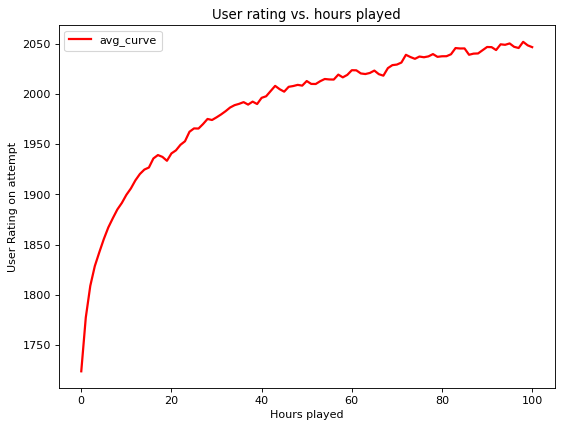

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
N_RAND = 5
colors = sns.color_palette("hls", N_RAND)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#for i,player in enumerate(user_rating_vals[:N_RAND]):
#    color = colors[i]
#    plt.plot(player,c=color)
plt.plot(avg_curve_vals,label='avg_curve',c='red',linewidth=2)
plt.legend(loc=2)
plt.title('User rating vs. hours played')
plt.xlabel('Hours played')
plt.ylabel('User Rating on attempt')
plt.savefig('../plots/user_rating_vs_hoursplayed.png')
plt.show()

In [21]:
#df = df.persist(StorageLevel.MEMORY_ONLY)
#time_spent_table = time_spent_table.persist(StorageLevel.MEMORY_ONLY)

<h1>Calculate User Performance as function of games played</h1>
<p>For each user calculate their average performance for each month they have played</p>

In [57]:
exp_user = df.filter((df.max_games_played >= 10000) & (df.userGamesPlayed <= 10000))

In [58]:
#Get the average rating per month for all users' average monthly ratings
avg_curve = exp_user.groupBy('userGamesPlayed')\
.agg(f.avg(exp_user.ratingUser))
avg_curve = avg_curve.orderBy('userGamesPlayed',ascending=True)
avg_curve_vals = np.array(avg_curve.select('avg(ratingUser)').collect())

In [59]:
unique_users = exp_user.select('user_hash').distinct().collect()

There are 2620 unique users remaining


In [64]:
import random
N_RAND = 200
rand_users = random.sample(unique_users,N_RAND)

In [66]:
#Filter out to get the first N games for each user in rand_users
rand_user_attempts = exp_user.filter(exp_user.user_hash.isin(rand_users))
#Order by user_hash and months_played so the ratings appear in the right
#order per user
rand_user_attempts = rand_user_attempts.orderBy(['user_hash','userGamesPlayed'],ascending=True)

user_rating_vals = np.array(rand_user_attempts.select('ratingUser').collect())
user_rating_vals = user_rating_vals.reshape(N_RAND,10000 + 1)

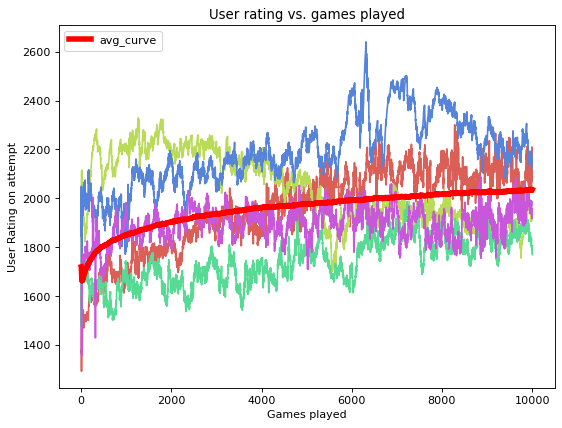

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
N_RAND = 5
colors = sns.color_palette("hls", N_RAND)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,player in enumerate(user_rating_vals[:N_RAND]):
    color = colors[i]
    plt.plot(player,c=color)
plt.plot(avg_curve_vals[:10001],label='avg_curve',c='red',linewidth=5)
plt.legend(loc=2)
plt.title('User rating vs. games played')
plt.xlabel('Games played')
plt.ylabel('User Rating on attempt')
plt.savefig('../plots/user_rating_vs_gamesplayed.png')
plt.show()

<h2>Number of Wins versus Rating</h2>

In [14]:
ratingWindow = W.partitionBy("user_hash").orderBy("create_date").rowsBetween(W.unboundedPreceding, W.unboundedFollowing)

df = df.withColumn("last_rating",f.last("ratingUser",True).over(ratingWindow))

In [8]:
won_games = df.filter(df.is_passed == 1).groupBy('user_hash')\
.count()
won_games = won_games.withColumnRenamed("count","num_wins")
df = df.join(won_games,"user_hash","inner")

In [16]:
#df = df.persist(StorageLevel.MEMORY_ONLY)
df = df.withColumnRenamed("max_rating","last_rating")
df.select(['user_hash','create_date','last_rating','num_wins','is_passed','ratingUser']).show(100)

+--------------------+-------------------+-----------+--------+---------+----------+
|           user_hash|        create_date|last_rating|num_wins|is_passed|ratingUser|
+--------------------+-------------------+-----------+--------+---------+----------+
|0003dec78e7aa4341...|2014-09-26 02:03:11|       1789|       2|        0|      1720|
|0003dec78e7aa4341...|2014-09-26 02:11:42|       1789|       2|        1|      1564|
|0003dec78e7aa4341...|2014-09-26 02:12:25|       1789|       2|        1|      1713|
|0003dec78e7aa4341...|2014-09-26 02:13:23|       1789|       2|        0|      1789|
|000dee0c69d063cff...|2010-03-31 09:03:51|       1308|       2|        0|      1720|
|000dee0c69d063cff...|2010-04-01 10:40:38|       1308|       2|        0|      1555|
|000dee0c69d063cff...|2010-04-01 10:44:28|       1308|       2|        0|      1478|
|000dee0c69d063cff...|2010-04-02 01:09:57|       1308|       2|        0|      1431|
|000dee0c69d063cff...|2010-04-02 01:14:55|       1308|       2|  

In [18]:
won_games = won_games.join(df.select(['user_hash','last_rating']),"user_hash","inner").persist(StorageLevel.MEMORY_ONLY)

In [20]:
won_games = won_games.drop_duplicates()

In [21]:
won_games.show(100)

+--------------------+--------+-----------+
|           user_hash|num_wins|last_rating|
+--------------------+--------+-----------+
|0003dec78e7aa4341...|       2|       1789|
|000dee0c69d063cff...|       2|       1308|
|0010c3696e6482d58...|       3|       1539|
|0012a8258bef5c23f...|       1|       1655|
|00180e215e732d3f4...|       1|       1814|
|001e6ec9af94888b3...|       5|       1919|
|002ba9853ef2e94b3...|       2|       1551|
|003320f1066576891...|       5|       1307|
|003f32a795c19e8f4...|       1|       1489|
|00476b387210d3a33...|      69|       1613|
|004dc0f55217e8c96...|       9|       2037|
|0050c866d0c682a45...|     927|       1967|
|0052384e0aaf692a6...|       2|       1556|
|00559182232478588...|       2|       1344|
|0059526b2e302bfd4...|       1|       1536|
|005c8448cc7cefe2d...|    1035|       1918|
|0060d8580881302f6...|      24|       1886|
|0065e14054edb58fe...|       4|       2658|
|0068f7f1a7e288fc8...|      15|       1323|
|00787c5f5e63c3a7b...|       5| 

In [22]:
won_games.count()

1919646

In [23]:
filtered_wins = np.array(won_games.filter(won_games.num_wins >= 50).select(['last_rating','num_wins']).collect())

In [27]:
sorted_wins = sorted(filtered_wins,key=lambda x: x[0])

In [36]:
x = [pair[0] for pair in sorted_wins]
y = [pair[1] for pair in sorted_wins]

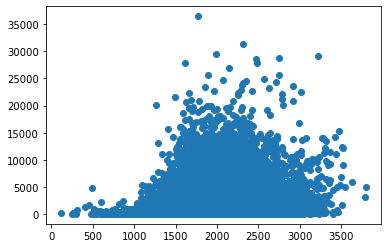

In [37]:
import matplotlib.pyplot as plt

plt.scatter(x,y)

<h1>Improvement over initial rating</h1>
<p>For attempts by users with a rating devation below a certain threshold, group users into rating bins based on their initial rating (the first attempt where their RD is less than threshold) and average their improvement over their initial rating per attempt

In [5]:
#Filter out attempts by users when they have a rating deviation greater than 80
stable_attempts = df.filter(df.varianceUser <= 80)
#Get the first stable attempt for each user and create new field called first_rating which stores this rating
ratingWindow = W.partitionBy("user_hash").orderBy("create_date").rowsBetween(W.unboundedPreceding, W.unboundedFollowing)
stable_attempts = stable_attempts.withColumn("first_rating",f.first("ratingUser",True).over(ratingWindow))

In [6]:
K = 100
#Divide the users into rating bins of size K based on their initial rating
stable_attempts = stable_attempts.withColumnRenamed("last_rating","first_rating")
stable_attempts = stable_attempts.withColumn("rating_bin",f.col("first_rating") - (f.col("first_rating") % K))

In [7]:
#Create a new field which stores the difference between current user rating and their initial rating
stable_attempts = stable_attempts.withColumn("ratingImprov",f.col("ratingUser") - f.col("first_rating"))

In [8]:
windowSpec = W.partitionBy("user_hash").orderBy("create_date")
#Add a field with number of games played up till each attempt for each user
stable_attempts = stable_attempts.withColumn("stableGamesPlayed",f.row_number().over(windowSpec)-1)

In [10]:
stable_attempts = stable_attempts.persist(StorageLevel.MEMORY_ONLY)
stable_attempts.select(['user_hash','create_date','first_rating','is_passed','ratingUser','varianceUser','userGamesPlayed','rating_bin','stableGamesPlayed']).show(500)
#stable_attempts = stable_attempts.filter(stable_attempts)

+--------------------+-------------------+------------+---------+----------+------------+---------------+----------+-----------------+
|           user_hash|        create_date|first_rating|is_passed|ratingUser|varianceUser|userGamesPlayed|rating_bin|stableGamesPlayed|
+--------------------+-------------------+------------+---------+----------+------------+---------------+----------+-----------------+
|00476b387210d3a33...|2010-12-03 03:42:37|        1675|        1|      1675|          80|             21|      1600|                0|
|00476b387210d3a33...|2010-12-03 03:43:04|        1675|        0|      1696|          78|             22|      1600|                1|
|00476b387210d3a33...|2010-12-03 03:43:35|        1675|        0|      1688|          77|             23|      1600|                2|
|00476b387210d3a33...|2010-12-03 03:44:36|        1675|        0|      1674|          75|             24|      1600|                3|
|00476b387210d3a33...|2010-12-03 03:44:54|        1675|

In [91]:
stable_attempts.printSchema()

root
 |-- user_hash: string (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- user_tactics_problem_id: string (nullable = true)
 |-- varianceUser: integer (nullable = true)
 |-- varianceProblem: integer (nullable = true)
 |-- ratingProblem: integer (nullable = true)
 |-- ratingUser: integer (nullable = true)
 |-- create_date: timestamp (nullable = true)
 |-- last_game_date: timestamp (nullable = true)
 |-- is_passed: integer (nullable = true)
 |-- correct_move_count: integer (nullable = true)
 |-- tactics_problem_id: string (nullable = true)
 |-- rating_change: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- userGamesPlayed: integer (nullable = true)
 |-- max_games_played: integer (nullable = true)
 |-- first_rating: integer (nullable = true)
 |-- rating_bin: integer (nullable = true)
 |-- ratingImprov: integer (nullable = true)
 |-- stableGamesPlayed: integer (nullable = true)
 |-- max_stable_played: integer (nullable = true)



In [93]:
#stable_attempts.write.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet')

<h3>Load existing parquet</h3>

In [21]:
stable_attempts = spark.read.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet',header=True,inferSchema = True)

In [17]:
#Create a field containing the max number of games played per user and join it
total_games = stable_attempts.groupBy('user_hash')\
.agg(max_('stableGamesPlayed')).withColumnRenamed("max(stableGamesPlayed)","max_stable_played")
stable_attempts  = stable_attempts.join(total_games,"user_hash","inner")

In [18]:
#get a list of all distinct rating bins in the data
rating_bins = stable_attempts.select('rating_bin').distinct().collect()
rating_bins = [bin_[0] for bin_ in rating_bins]

In [22]:
#Get rid of users that have played less than num attempts
NUM_ATTEMPTS = 500
selected_attempts = stable_attempts.filter((stable_attempts.max_stable_played >= NUM_ATTEMPTS) & (stable_attempts.stableGamesPlayed <= NUM_ATTEMPTS))

In [11]:
#rating_bin_counts = selected_attempts.groupBy('rating_bin').agg(max_("stableGamesPlayed"))
#rating_bin_counts = rating_bin_counts.withColumnRenamed('max(stableGamesPlayed)','max_games')

In [23]:
rating_bin_user_counts = selected_attempts.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')

In [24]:
#Get the rating bins that have at least NUM_ATTEMPTS made which enables reshaping properly for plotting
MIN_USER_NUM = 1000
valid_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
valid_options = [bin_[0] for bin_ in valid_options]
valid_options = sorted(valid_options)

In [25]:
valid_options

[1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

In [26]:
filtered_attempts = selected_attempts.filter(selected_attempts.rating_bin.isin(valid_options)).persist(StorageLevel.MEMORY_ONLY)

In [27]:
#Get the avg rating improvement for each rating bin
avg_curve = filtered_attempts.groupBy(['rating_bin','stableGamesPlayed'])\
.agg(f.avg(filtered_attempts.ratingImprov))
avg_curve = avg_curve.orderBy(['rating_bin','stableGamesPlayed'],ascending=True)
avg_curve_vals = np.array(avg_curve.select('avg(ratingImprov)').collect())
avg_curve_vals = avg_curve_vals.reshape(len(valid_options),NUM_ATTEMPTS+1)

In [34]:
#Get full average for all rating bins
full_avg_curve = selected_attempts.groupBy('stableGamesPlayed')\
.agg(f.avg(selected_attempts.ratingImprov))
full_avg_curve = full_avg_curve.orderBy('stableGamesPlayed',ascending=True)
full_avg_curve_vals = np.array(full_avg_curve.select('avg(ratingImprov)').collect())

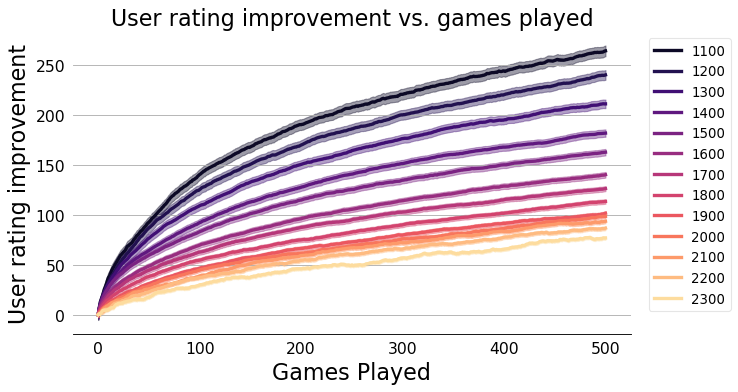

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib.font_manager
#colors = sns.color_palette("hls", len(valid_options))
colors = sns.color_palette("magma", len(valid_options))
plt.figure(figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update(rc_params)
x_range = list(range(NUM_ATTEMPTS+1))
for i,curve in enumerate(avg_curve_vals):
    #print(valid_options[i])
    color = colors[i]
    stderror = np.sqrt(np.var(curve)/len(curve))
    plt.plot(curve,c=color,label=valid_options[i],linewidth=3)
    plt.fill_between(x_range,curve-(1.96*stderror),curve+(1.96*stderror),alpha=0.4,color=color)
#plt.plot(full_avg_curve_vals,label='avg_curve',c='red',linewidth=4)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.title('User rating improvement vs. games played')
plt.xlabel('Games Played')
plt.ylabel('User rating improvement')
#plt.savefig('../plots/user_performance_over_time_plots/500_attempts_1000_user_improv.png', bbox_inches='tight')
plt.show()

In [68]:
def generate_plot(std_dev_vals,rating_curves,valid_options,K):
    colors = sns.color_palette("magma", len(valid_options))
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update(rc_params)
    x_range = list(range(K+1))
    for i,curve in enumerate(rating_curves):
        #print(valid_options[i])
        color = colors[i]
        std_devs = std_dev_vals[i]
        plt.plot(curve,c=color,label=valid_options[i])
        for j in x_range:
            plt.fill_between(x_range,curve-(1.96*std_devs[j]),curve+(1.96*std_devs[j]),alpha=0.4,color=color)
    #plt.plot(avg_curve,label='avg_curve',c='red',linewidth=4)
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.title('User rating improvement vs. stable games played')
    plt.xlabel('Stable attempt number')
    plt.ylabel('Rating improv')
    #plt.savefig('../plots/user_performance_over_time_plots/{}_attempts_1000_user_improv_stddev_shaded.png'.format(K), bbox_inches='tight')

In [72]:
std_dev_vals[0]

array([143.9748539 , 152.88940627, 159.77878193, ..., 131.46125667,
       132.8115136 , 136.2373105 ])

In [61]:
#perform attempt filtering and plot generation in a loop
MIN_USER_NUM = 1000
for K in range(1000,3000,500):
    print('Doing plot for {} attempts'.format(K))
    #Filter down to attempts made by users that have made at least K attempts and get only K of those attempts
    selected_attempts = stable_attempts.filter((stable_attempts.max_stable_played >= K) & (stable_attempts.stableGamesPlayed <= K))
    #Filter out attempts for users in rating bins that have at least MIN_USER_NUM users in that bin
    rating_bin_user_counts = selected_attempts.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
    rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')    
    valid_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
    valid_options = sorted([bin_[0] for bin_ in valid_options])
    #valid_options = np.load('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_valid_options.npy'.format(K))
    #valid_options = sorted(valid_options)
    filtered_attempts = selected_attempts.filter(selected_attempts.rating_bin.isin(valid_options))
    #Get the avg rating improvement for each rating bin
    #avg_curve = filtered_attempts.groupBy(['rating_bin','stableGamesPlayed'])\
    #.agg(f.avg(filtered_attempts.ratingImprov))
    #avg_curve = avg_curve.orderBy(['rating_bin','stableGamesPlayed'],ascending=True)
    #avg_curve_vals = np.array(avg_curve.select('avg(ratingImprov)').collect())
    #avg_curve_vals = avg_curve_vals.reshape(len(valid_options),K+1)
    std_dev_table = filtered_attempts.groupBy(['rating_bin','stableGamesPlayed'])\
    .agg(f.stddev(filtered_attempts.ratingImprov))
    std_devs = std_dev_table.orderBy(['rating_bin','stableGamesPlayed'],ascending=True)
    std_dev_vals = np.array(std_dev_table.select('stddev_samp(ratingImprov)').collect())
    std_dev_vals = std_dev_vals.reshape(len(valid_options),K+1)
    #np.save('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_stddev_shaded.npy'.format(K),avg_curve_vals)
    np.save('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_stddev_vals.npy'.format(K),std_dev_vals)
    #np.save('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_valid_options.npy'.format(K),valid_options)
    #Generate and save plot
    #generate_plot(avg_curve_vals,valid_options,K)
    print('Done with plot for {} attempts'.format(K))

Doing plot for 1000 attempts
Done with plot for 1000 attempts
Doing plot for 1500 attempts
Done with plot for 1500 attempts
Doing plot for 2000 attempts
Done with plot for 2000 attempts
Doing plot for 2500 attempts
Done with plot for 2500 attempts


Done with plot for 1000 attempts
Done with plot for 1500 attempts
Done with plot for 2000 attempts
Done with plot for 2500 attempts


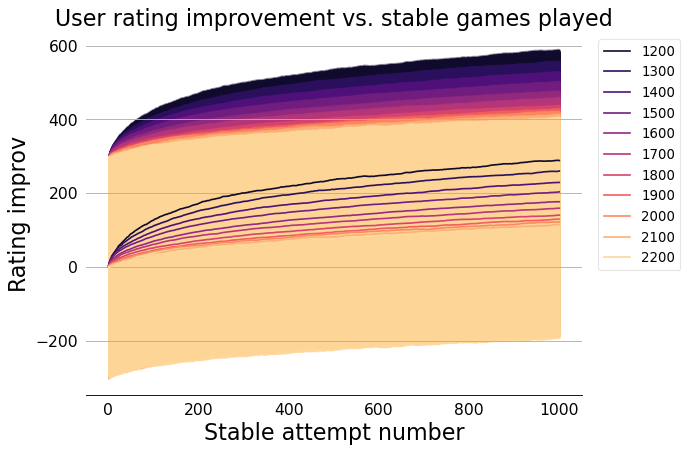

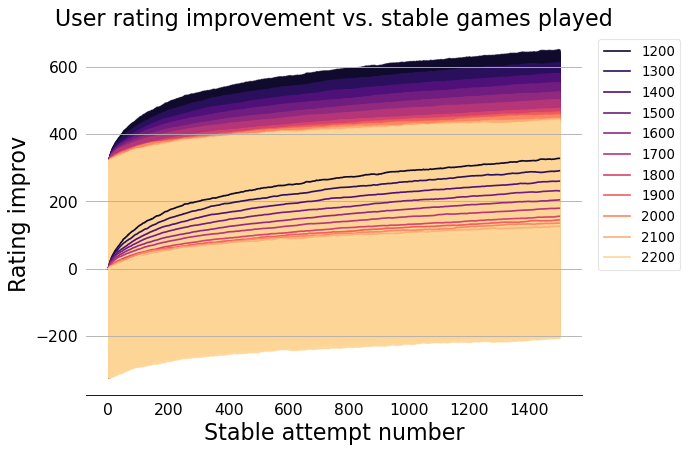

Error in callback <function flush_figures at 0x7f38b05b20d0> (for post_execute):


KeyboardInterrupt: 

In [69]:
#perform attempt filtering and plot generation in a loop from saved numpy arrays
MIN_USER_NUM = 1000
for K in range(1000,3000,500):
    avg_curve_vals = np.load('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_stddev_shaded.npy'.format(K))
    valid_options = np.load('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_valid_options.npy'.format(K))
    std_dev_vals = np.load('../plots/numpy/stable_games_played_plots/{}_attempts_1000_user_improv_stddev_vals.npy'.format(K))
    generate_plot(std_dev_vals,avg_curve_vals,valid_options,K)
    print('Done with plot for {} attempts'.format(K))

<h2>Rating improvement over time spent in tactics</h2>

In [101]:
stable_attempts = spark.read.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet',header=True,inferSchema = True)
stable_attempts = stable_attempts.filter(stable_attempts.seconds <= 3600)

In [102]:
duration_window = W.partitionBy("user_hash").orderBy("create_date").rowsBetween(
    W.unboundedPreceding,  # Take all rows from the beginning of frame
    W.currentRow           # To current row
)
stable_attempts = stable_attempts.withColumn("time_spent", f.sum("seconds").over(duration_window))

In [103]:
stable_attempts = stable_attempts.withColumn('hoursSpent',(f.col('time_spent')/3600).cast('int'))

In [104]:
max_hours = stable_attempts.groupBy('user_hash')\
.agg(max_('hoursSpent')).withColumnRenamed("max(hoursSpent)","max_hours")
stable_attempts  = stable_attempts.join(max_hours,"user_hash","inner")

In [105]:
K = 50
exp_user = stable_attempts.filter((stable_attempts.max_hours >= 50) & (stable_attempts.hoursSpent <= 50))

In [107]:
exp_user = exp_user.persist(StorageLevel.MEMORY_ONLY)

In [110]:
MIN_USER_NUM = 250

In [111]:
rating_bin_user_counts = exp_user.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')    
valid_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
valid_options = sorted([bin_[0] for bin_ in valid_options])

In [115]:
#Filter out to get the first N games for each user in rand_users
avg_hour_table = exp_user.filter(exp_user.rating_bin.isin(valid_options)).groupBy(['rating_bin','hoursSpent'])\
.agg(f.avg('ratingImprov'))
#Order by user_hash and months_played so the ratings appear in the right
#order per user

rating_curves = avg_hour_table.orderBy(['rating_bin','hoursSpent'],ascending=True)

rating_curve_vals = np.array(rating_curves.select('avg(ratingImprov)').collect())
rating_curve_vals = rating_curve_vals.reshape(len(valid_options),K + 1)

In [4]:
#np.save('../important/user_improv_curves/50_hours_250_user_improv.npy',rating_curve_vals)
rating_curve_vals = np.load('../important/user_improv_curves/50_hours_250_user_improv.npy')
valid_options = [1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]

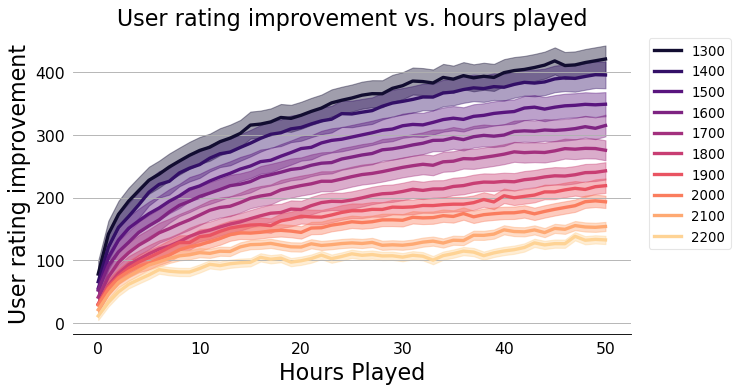

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib.font_manager
#colors = sns.color_palette("hls", len(valid_options))
colors = sns.color_palette("magma", len(valid_options))
plt.figure(figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update(rc_params)
x_range = list(range(0,rating_curve_vals[0].shape[0]))
for i,curve in enumerate(rating_curve_vals):
    #print(valid_options[i])
    color = colors[i]
    stderror = np.sqrt(np.var(curve)/len(curve))
    #Add 1.96 times the standard error to get the 95% confidence interval 
    plt.plot(curve,c=color,label=valid_options[i],linewidth=3)
    plt.fill_between(x_range,curve-(1.96*stderror),curve+(1.96*stderror),alpha=0.4,color=color)
#plt.plot(full_avg_curve_vals,label='avg_curve',c='red',linewidth=4)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.title('User rating improvement vs. hours played')
plt.xlabel('Hours Played')
plt.ylabel('User rating improvement')
plt.savefig('../plots/user_performance_over_time_plots/50_hours_250_stddev_shading_user_improv.png', bbox_inches='tight')
plt.show()

<h2>Rating improvement over months played</h2>

In [3]:
stable_attempts = spark.read.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet',header=True,inferSchema = True)

In [5]:
#Get the earliest date for each user that appears in the dataframe and 
#store as a new column min_date in first_dates table
first_dates = stable_attempts.groupBy('user_hash').agg(min_('create_date')).withColumnRenamed("min(create_date)","min_date")
#first_dates = first_dates.withColumnRenamed("min(create_date)","min_date")
#Join min_date to each row in the original dataframe
stable_attempts = stable_attempts.join(first_dates, "user_hash","inner")
#Create a new column in the dataframe with the number of months since first attempt for each user
stable_attempts = stable_attempts.withColumn("months_played",f.months_between(f.col("create_date"),f.col("min_date")).cast('int'))
temp = stable_attempts.groupBy('user_hash')\
.agg(max_('months_played')).withColumnRenamed("max(months_played)","max_months")
stable_attempts  = stable_attempts.join(temp,"user_hash","inner")

In [18]:
MONTHS = 24
exp_user = stable_attempts.filter((stable_attempts.max_months >= MONTHS) & (stable_attempts.months_played <= MONTHS)).persist(StorageLevel.MEMORY_ONLY)

In [19]:
MIN_USER_NUM = 250
rating_bin_user_counts = exp_user.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')    
valid_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
valid_options = sorted([bin_[0] for bin_ in valid_options])

In [21]:
#Filter out to get the first N games for each user in rand_users
avg_hour_table = exp_user.filter(exp_user.rating_bin.isin(valid_options)).groupBy(['rating_bin','months_played'])\
.agg(f.avg('ratingImprov'))
#Order by user_hash and months_played so the ratings appear in the right
#order per user

rating_curves = avg_hour_table.orderBy(['rating_bin','months_played'],ascending=True)

rating_curve_vals = np.array(rating_curves.select('avg(ratingImprov)').collect())
rating_curve_vals = rating_curve_vals.reshape(len(valid_options),MONTHS + 1)

In [26]:
filename = '../important/user_improv_curves/{}_months_{}_user_improv'.format(MONTHS,MIN_USER_NUM)
np.save(filename+'.npy',rating_curve_vals)
np.save(filename+'_valid_options.npy',valid_options)

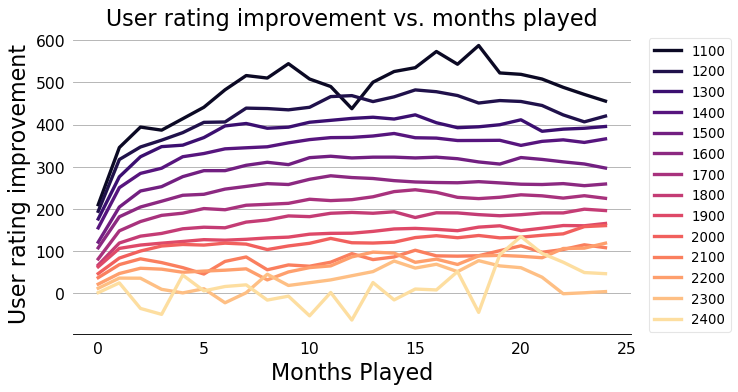

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib.font_manager
#colors = sns.color_palette("hls", len(valid_options))
colors = sns.color_palette("magma", len(valid_options))
plt.figure(figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update(rc_params)
for i,curve in enumerate(rating_curve_vals):
    #print(valid_options[i])
    color = colors[i]
    plt.plot(curve,c=color,label=valid_options[i],linewidth=3)
#plt.plot(full_avg_curve_vals,label='avg_curve',c='red',linewidth=4)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.title('User rating improvement vs. months played')
plt.xlabel('Months Played')
plt.ylabel('User rating improvement')
plt.savefig('../plots/user_performance_over_time_plots/{}_months_{}_user_improv.png'.format(MONTHS,MIN_USER_NUM), bbox_inches='tight')
plt.show()

<h2>User improvement over by games played vs rating bin</h2>

In [12]:
stable_attempts = spark.read.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet',header=True,inferSchema = True)

In [14]:
K_list = [50,100,150,200,250,300]
#Get rid of users that have played less than num attempts
NUM_ATTEMPTS = 300
selected_attempts = stable_attempts.filter((stable_attempts.max_stable_played >= NUM_ATTEMPTS) & (stable_attempts.stableGamesPlayed <= NUM_ATTEMPTS))
stable_game_intervals = selected_attempts.filter(selected_attempts.stableGamesPlayed.isin(K_list))

In [18]:
rating_bin_user_counts = stable_game_intervals.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')

In [20]:
#Get the rating bins that have at least NUM_ATTEMPTS made which enables reshaping properly for plotting
MIN_USER_NUM = 1000
valid_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
valid_options = [bin_[0] for bin_ in valid_options]
valid_options = sorted(valid_options)

In [22]:
filtered_attempts = stable_game_intervals.filter(stable_game_intervals.rating_bin.isin(valid_options)).persist(StorageLevel.MEMORY_ONLY)

In [23]:
#Get the avg rating improvement for each rating bin
avg_curve = filtered_attempts.groupBy(['stableGamesPlayed','rating_bin'])\
.agg(f.avg(filtered_attempts.ratingImprov))
avg_curve = avg_curve.orderBy(['rating_bin','stableGamesPlayed'],ascending=True)
avg_curve_vals = np.array(avg_curve.select('avg(ratingImprov)').collect())

In [73]:
avg_curve_vals = avg_curve_vals.reshape(len(valid_options),len(K_list))
#avg_curve_vals = avg_curve_vals.reshape(len(K_list),len(valid_options))

In [26]:
avg_curve_vals = avg_curve_vals.reshape(len(K_list),len(valid_options))

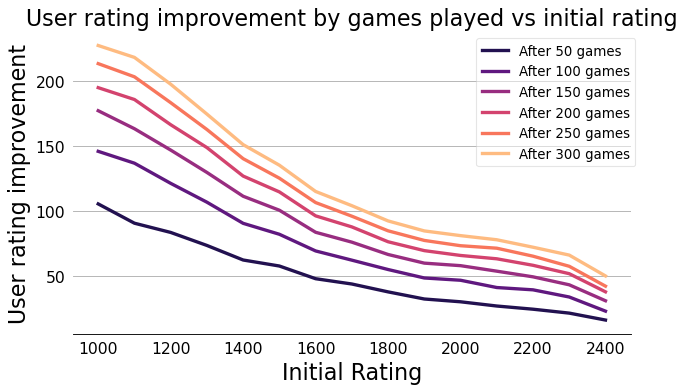

In [103]:
import seaborn as sns
colors = sns.color_palette("magma", len(K_list))
plt.figure(figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update(rc_params)
for i in range(len(K_list)):
    improv_vals = []
    for j in range(len(valid_options)):
        improv_vals.append(avg_curve_vals[j,i])
    plt.plot(valid_options,improv_vals,label='After {} games'.format(K_list[i]),c=colors[i],linewidth=3)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.title('User rating improvement by games played vs initial rating')
plt.xlabel('Initial Rating')
plt.ylabel('User rating improvement')
plt.savefig('../plots/user_performance_over_time_plots/{}_game_bins_{}_rating_bins.png'.format(len(K_list),len(valid_options)), bbox_inches='tight')
plt.show()

<h2>User improvement vs users that have played x amount of games</h2>

In [82]:
stable_attempts = spark.read.parquet('/w/225/1/chess/tactics/parquet/stable_attempts.parquet',header=True,inferSchema = True)

In [83]:
K = 100
stable_attempts = stable_attempts.withColumn("games_bin",f.col("max_stable_played") - (f.col("max_stable_played") % K))

In [84]:
#Filter out rating bins with less than the min number of users
MIN_USER_NUM = 1000
rating_bin_user_counts = stable_attempts.groupBy('rating_bin').agg(f.countDistinct('user_hash'))
rating_bin_user_counts = rating_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')

In [85]:
valid_rating_options = rating_bin_user_counts.filter(rating_bin_user_counts.user_count >= MIN_USER_NUM).select('rating_bin').collect()
valid_rating_options = [bin_[0] for bin_ in valid_rating_options]
valid_rating_options = sorted(valid_rating_options)

In [86]:
filtered_attempts = stable_attempts.filter(stable_attempts.rating_bin.isin(valid_rating_options))

In [87]:
#Filter out game bins that have less than the min number of users
games_bin_user_counts = filtered_attempts.groupBy('games_bin').agg(f.countDistinct('user_hash'))
games_bin_user_counts = games_bin_user_counts.withColumnRenamed('count(user_hash)','user_count')

In [88]:
valid_options = games_bin_user_counts.filter(games_bin_user_counts.user_count >= MIN_USER_NUM).select('games_bin').collect()
valid_options = [bin_[0] for bin_ in valid_options]
valid_options = sorted(valid_options)

In [89]:
filtered_attempts = filtered_attempts.filter(filtered_attempts.games_bin.isin(valid_options))
filtered_attempts = filtered_attempts.filter(filtered_attempts.stableGamesPlayed == filtered_attempts.max_stable_played)#.persist(StorageLevel.MEMORY_ONLY)

In [103]:
rating_bin_counts = avg_curve.groupby('games_bin').agg(f.countDistinct('rating_bin')).show(100)

+---------+-----------------+
|games_bin|count(rating_bin)|
+---------+-----------------+
|     1700|               17|
|     2200|               17|
|     1500|               17|
|      300|               17|
|     1300|               17|
|     1400|               17|
|     1100|               17|
|      500|               17|
|     1800|               17|
|     1600|               17|
|      900|               17|
|      800|               17|
|      100|               17|
|     1000|               17|
|     1200|               17|
|      400|               17|
|     2100|               16|
|      200|               17|
|      600|               17|
|     2000|               16|
|      700|               17|
|        0|               17|
|     1900|               17|
+---------+-----------------+



In [108]:
#Get the avg rating improvement for each rating bin
avg_curve = filtered_attempts.groupBy(['games_bin','rating_bin'])\
.agg(f.avg(filtered_attempts.ratingImprov))
avg_curve = avg_curve.orderBy(['games_bin','rating_bin'],ascending=True)
avg_curve = avg_curve.filter((avg_curve.games_bin != 2100) & (avg_curve.games_bin != 2000 ))
avg_curve_vals = np.array(avg_curve.select('avg(ratingImprov)').collect())

In [110]:
avg_curve_vals = avg_curve_vals.reshape(len(valid_rating_options),len(valid_options)-2)

In [111]:
valid_options = [val for val in valid_options if val != 2100 and val != 2000]

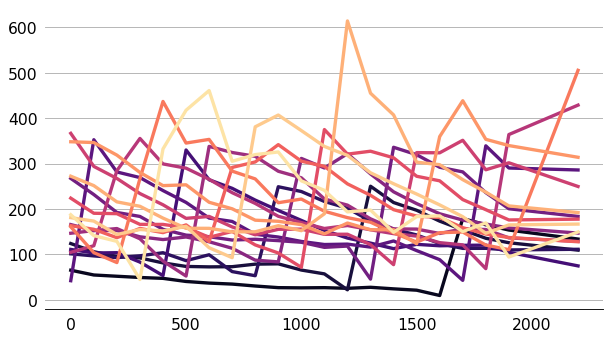

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("magma", len(valid_rating_options))
plt.figure(figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update(rc_params)
for i in range(len(valid_rating_options)):
    plt.plot(valid_options,avg_curve_vals[i],linewidth=3,color=colors[i])
#plt.legend(bbox_to_anchor=(1.02, 1))
#plt.title('User rating improvement by games played vs initial rating')
#plt.xlabel('Initial Rating')
#plt.ylabel('User rating improvement')
plt.savefig('../plots/user_performance_over_time_plots/improvement_on_last_attempt_vs_users_of_x_attempts.png', bbox_inches='tight')
plt.show()